In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
import seaborn as sns
import scipy.stats as stats
from syntren import *
from gnw import *
from tf_utils import predict
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
root_gene = 'CRP'
minimum_evidence = 'weak'
max_depth = np.inf

# ---------------
# Load real data
# ---------------
expr, gene_symbols, sample_names = load_ecoli(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)
nb_genes = len(gene_symbols)

# Split data into train and test sets
train_idxs, test_idxs = split_train_test_v3(sample_names)
nb_train = len(train_idxs)
expr_train = expr[train_idxs, :]
expr_test = expr[test_idxs, :]

# Train statistics
r_mean = np.mean(expr_train, axis=0)
r_std = np.std(expr_train, axis=0)
r_min = np.min(expr_train)
r_max = np.max(expr_train)

# Conditions
_, encoded_conditions, vocab_dicts = ecoli_discrete_conditions(sample_names)
print('Conditions: ', encoded_conditions)
encoded_conditions = np.int32(encoded_conditions)

# Split data into train and test sets
train_idxs, test_idxs = split_train_test_v3(sample_names)
expr = np.float32(expr)
expr_train = expr[train_idxs, :]
expr_test = expr[test_idxs, :]
cond_train = encoded_conditions[train_idxs, :]
cond_test = encoded_conditions[test_idxs, :]
num_covs_test = np.zeros(shape=[cond_test.shape[0], 1])  # Dummy

Found 4297 genes in datafile
Found 1208 genes in CRP regulatory network
4297 genes not in gene subset. Selecting 1076 genes ...
Conditions:  [[0 0 1 ... 1 0 1]
 [0 0 1 ... 1 0 1]
 [0 0 1 ... 1 0 1]
 ...
 [5 1 0 ... 1 0 1]
 [5 1 0 ... 1 0 1]
 [5 1 0 ... 1 0 1]]


In [3]:
# --------------------
# Load synthetic data
# --------------------
gen = tfk.models.load_model('checkpoints/models/gen_ecoli.h5')
s_expr = predict(cond_test, num_covs_test, gen, z=None, training=False)

# Adjust scale
mean = np.mean(s_expr, axis=0)
std = np.std(s_expr, axis=0)
s_expr = (s_expr - mean)/std
s_expr = s_expr * r_std + r_mean

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

gan_expr = s_expr

/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


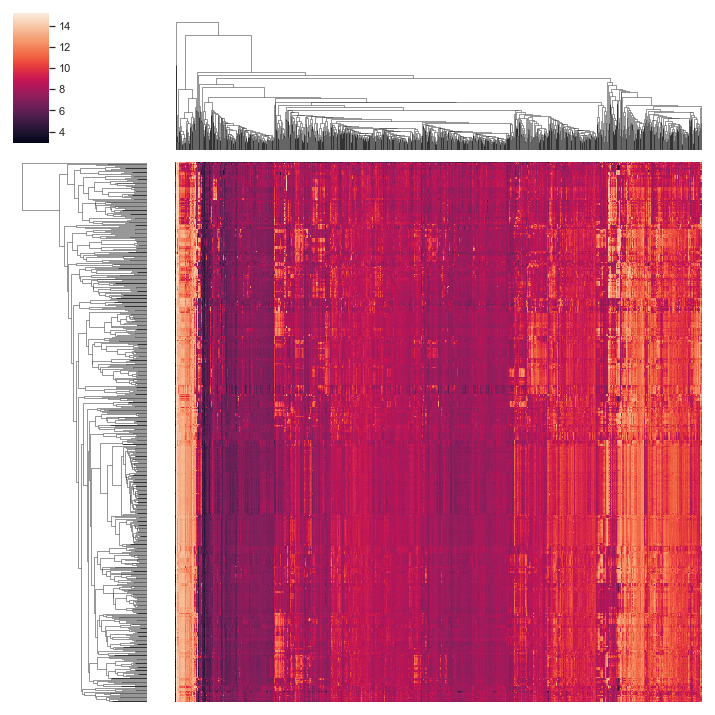

In [4]:
g = sns.clustermap(expr_train, xticklabels=False, yticklabels=False)

/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


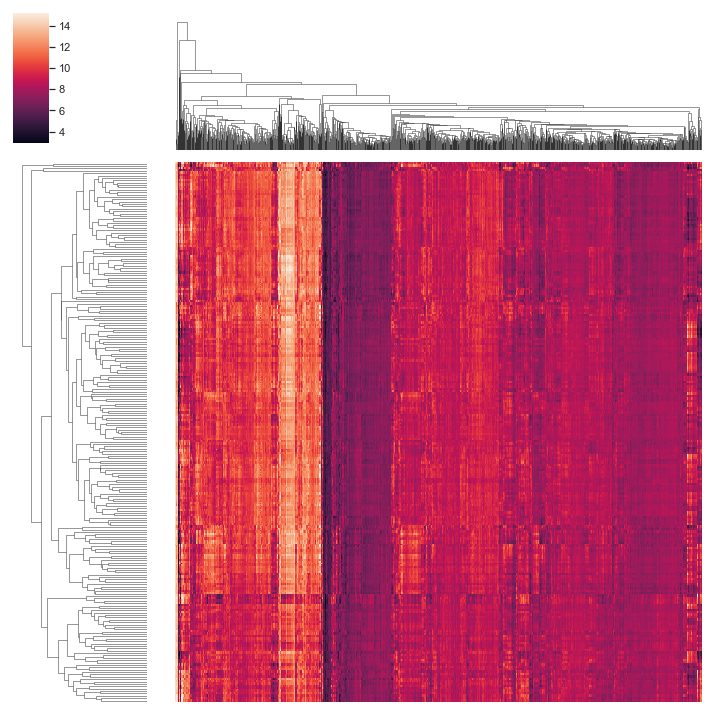

In [5]:
g = sns.clustermap(gan_expr, xticklabels=False, yticklabels=False)

In [6]:
### SynTReN data ###
s_expr, s_gene_symbols = syntren_results(bionoise=0.8,
                                         expnoise=0.0,
                                         corrnoise=0.0,
                                         minimum_evidence='Weak',
                                         nb_background=0)

# Align synthetic gene symbols
idxs = [s_gene_symbols.index(gene) for gene in gene_symbols]
s_expr = s_expr[:nb_train, idxs]
assert (np.array(s_gene_symbols)[idxs] == np.array(gene_symbols)).all()

# Adjust scale of SynTReN data
mean = np.mean(s_expr, axis=0)
std = np.std(s_expr, axis=0)
s_expr = (s_expr - mean)/std
s_expr = s_expr * r_std + r_mean

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

syn_expr = s_expr

### GNW data ###
s_expr, s_gene_symbols = gnw_results(noise=0.1,
                                     minimum_evidence='Weak',
                                     break_loops=False)

# Align synthetic gene symbols
idxs = [s_gene_symbols.index(gene) for gene in gene_symbols]
s_expr = s_expr[:nb_train, idxs]
assert (np.array(s_gene_symbols)[idxs] == np.array(gene_symbols)).all()

# Adjust scale of GNW data
mean = np.mean(s_expr, axis=0)
std = np.std(s_expr, axis=0)
s_expr = (s_expr - mean)/std
s_expr = s_expr * r_std + r_mean

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

gnw_expr = s_expr

/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


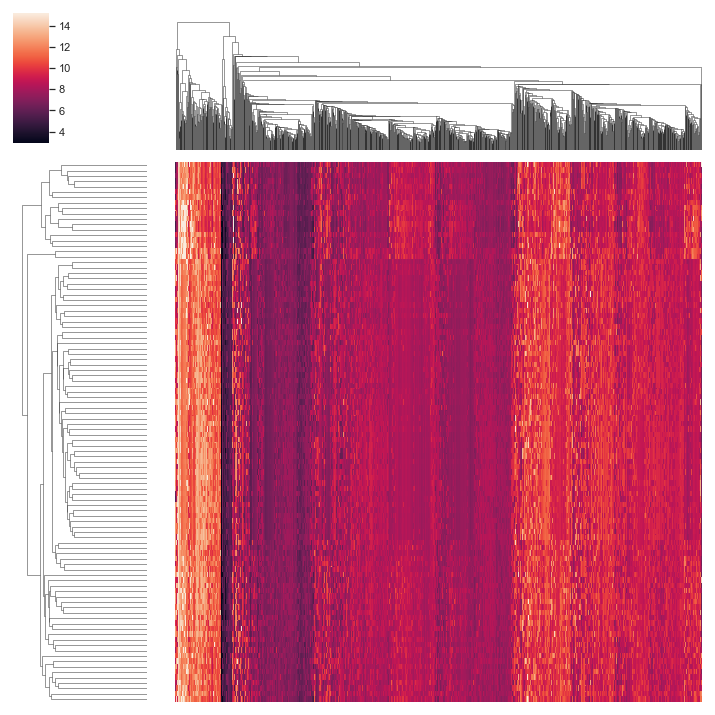

In [7]:
g = sns.clustermap(syn_expr, xticklabels=False, yticklabels=False)

# Compare background distributions

In [8]:
train_back_corr = correlations_list(expr_train, expr_train)
r_back_corr = correlations_list(expr_test, expr_test)
syn_back_corr = correlations_list(syn_expr, syn_expr)
gnw_back_corr = correlations_list(gnw_expr, gnw_expr)
gan_back_corr = correlations_list(gan_expr, gan_expr)

(-1, 1)

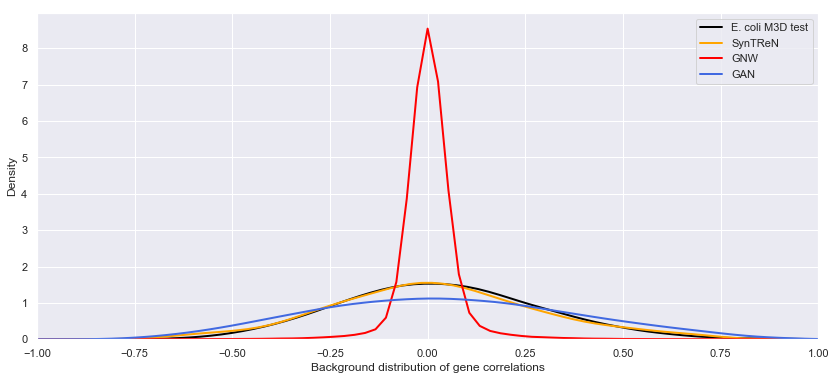

In [9]:
plt.figure(figsize=(14, 6))
# ax = plot_distribution(train_back_corr, label='E. coli M3D train')
ax = plot_distribution(r_back_corr, label='E. coli M3D test', color='black')
ax = plot_distribution(syn_back_corr, label='SynTReN', color='orange', ax=ax)
ax = plot_distribution(gnw_back_corr, label='GNW', color='red', ax=ax)
ax = plot_distribution(gan_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='GAN', color='royalblue')
ax.set_xlim((-1, 1))
# plt.tight_layout()
# plt.savefig('back_comp.pdf', bbox_inches = 'tight', pad_inches = 0);

# Intensity histograms

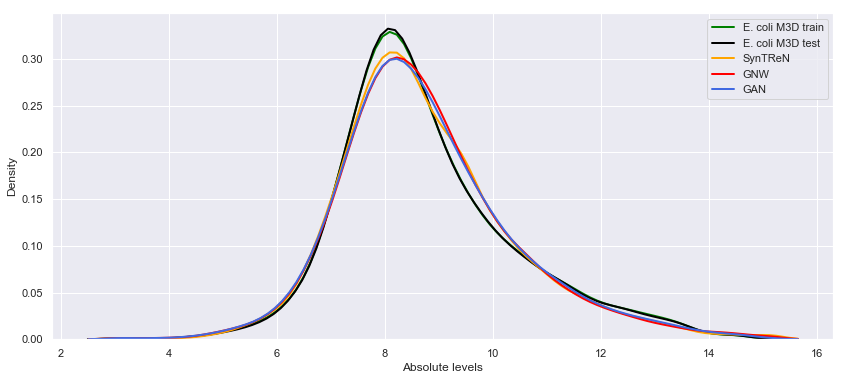

In [10]:
plt.figure(figsize=(14, 6))
ax = plot_intensities(expr_train, dataset_name='E. coli M3D train', color='green', plot_quantiles=False)
ax = plot_intensities(expr_test, dataset_name='E. coli M3D test', color='black', plot_quantiles=False)
ax = plot_intensities(syn_expr, dataset_name='SynTReN', color='orange', plot_quantiles=False, ax=ax);
ax = plot_intensities(gnw_expr, dataset_name='GNW', color='red', plot_quantiles=False, ax=ax);
ax = plot_intensities(gan_expr, dataset_name='GAN', color='royalblue', plot_quantiles=False, ax=ax);

# Gene ranges histograms

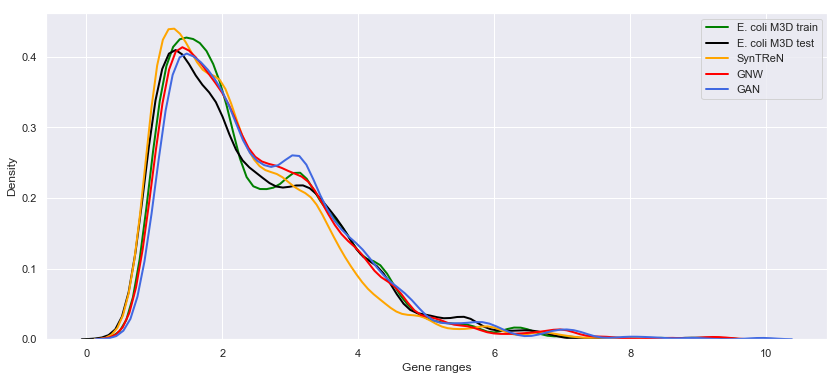

In [11]:
plt.figure(figsize=(14, 6))
ax = plot_gene_ranges(expr_train, dataset_name='E. coli M3D train', color='green')
ax = plot_gene_ranges(expr_test, dataset_name='E. coli M3D test', color='black')
ax = plot_gene_ranges(syn_expr, dataset_name='SynTReN', color='orange', ax=ax)
ax = plot_gene_ranges(gnw_expr, dataset_name='GNW', color='red', ax=ax)
plot_gene_ranges(gan_expr, dataset_name='GAN', color='royalblue', ax=ax);

# TF-TG histogram (using synthetic background distribution)

In [12]:
train_tf_tg_corr, train_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols)
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_test, gene_symbols)
gan_tf_tg_corr, gan_tg_tg_corr = compute_tf_tg_corrs(gan_expr, gene_symbols)
train_back_corr = correlations_list(expr_train, expr_train)
r_back_corr = correlations_list(expr_test, expr_test)
gan_back_corr = correlations_list(gan_expr, gan_expr)
syn_tf_tg_corr, syn_tg_tg_corr = compute_tf_tg_corrs(syn_expr, gene_symbols)
gnw_tf_tg_corr, gnw_tg_tg_corr = compute_tf_tg_corrs(gnw_expr, gene_symbols)

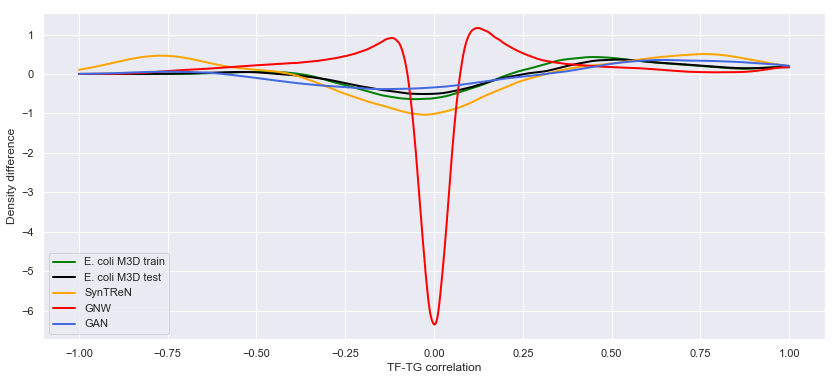

In [13]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(train_tf_tg_corr, train_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D train', color='green')
ax = plot_difference_histogram(r_tf_tg_corr, r_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D test', color='black')
ax = plot_difference_histogram(syn_tf_tg_corr, syn_back_corr, 'TF-TG correlation', dataset_name='SynTReN', color='orange', ax=ax); 
ax = plot_difference_histogram(gnw_tf_tg_corr, gnw_back_corr, 'TF-TG correlation', dataset_name='GNW', color='red', ax=ax);
plot_difference_histogram(gan_tf_tg_corr, gan_back_corr, 'TF-TG correlation', dataset_name='GAN', color='royalblue', ax=ax); 

# TG-TG histogram (using synthetic background distribution)

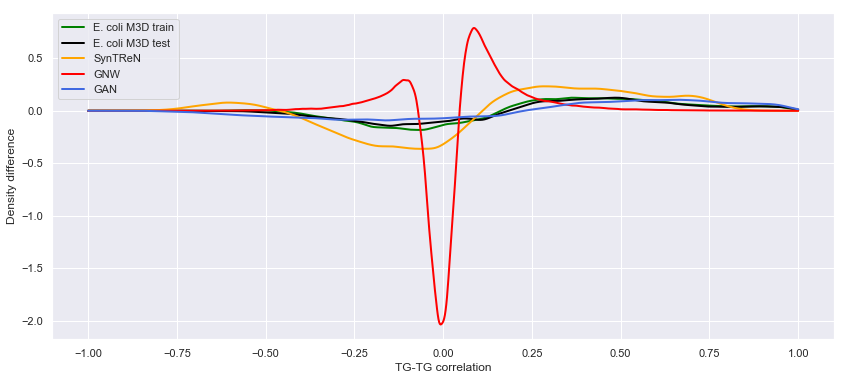

In [14]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(train_tg_tg_corr, train_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D train', color='green')
ax = plot_difference_histogram(r_tg_tg_corr, r_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D test', color='black', ax=ax)
ax = plot_difference_histogram(syn_tg_tg_corr, syn_back_corr, 'TG-TG correlation', dataset_name='SynTReN', color='orange', ax=ax);
ax = plot_difference_histogram(gnw_tg_tg_corr, gnw_back_corr, 'TG-TG correlation', dataset_name='GNW', color='red', ax=ax);
ax = plot_difference_histogram(gan_tg_tg_corr, gan_back_corr, 'TG-TG correlation', dataset_name='GAN', color='royalblue', ax=ax);

# TF activity histogram

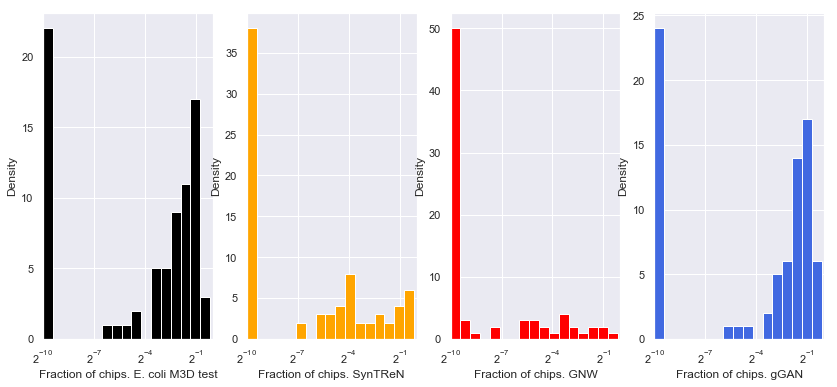

In [15]:
plt.figure(figsize=(14, 6))
plt.subplot(141)
plot_tf_activity_histogram(expr_test, gene_symbols, xlabel='Fraction of chips. E. coli M3D test', color='black')
plt.subplot(142)
plot_tf_activity_histogram(syn_expr, gene_symbols, xlabel='Fraction of chips. SynTReN', color='orange')
plt.subplot(143)
plot_tf_activity_histogram(gnw_expr, gene_symbols, xlabel='Fraction of chips. GNW', color='red')
plt.subplot(144)
plot_tf_activity_histogram(gan_expr, gene_symbols, xlabel='Fraction of chips. gGAN', color='royalblue');

# Quantitative analysis

In [16]:
scores = compute_scores(expr_test, gan_expr, gene_symbols)
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

scores = compute_scores(expr_test, expr_train, gene_symbols)
print('\nReal')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

gGAN
S_dist: 0.8518880516314716
S_dend: 0.45867292181954944
S_sdcc: 0.0014787194436877422
S_tftg: 0.8490661973353215
S_tgtg: 0.9044771130188353

Real
S_dist: 0.9109078628857958
S_dend: 0.5197255377505843
S_sdcc: 0.0002194876083136418
S_tftg: 0.9143066289994949
S_tgtg: 0.946756621367894


# Analyze gene histograms

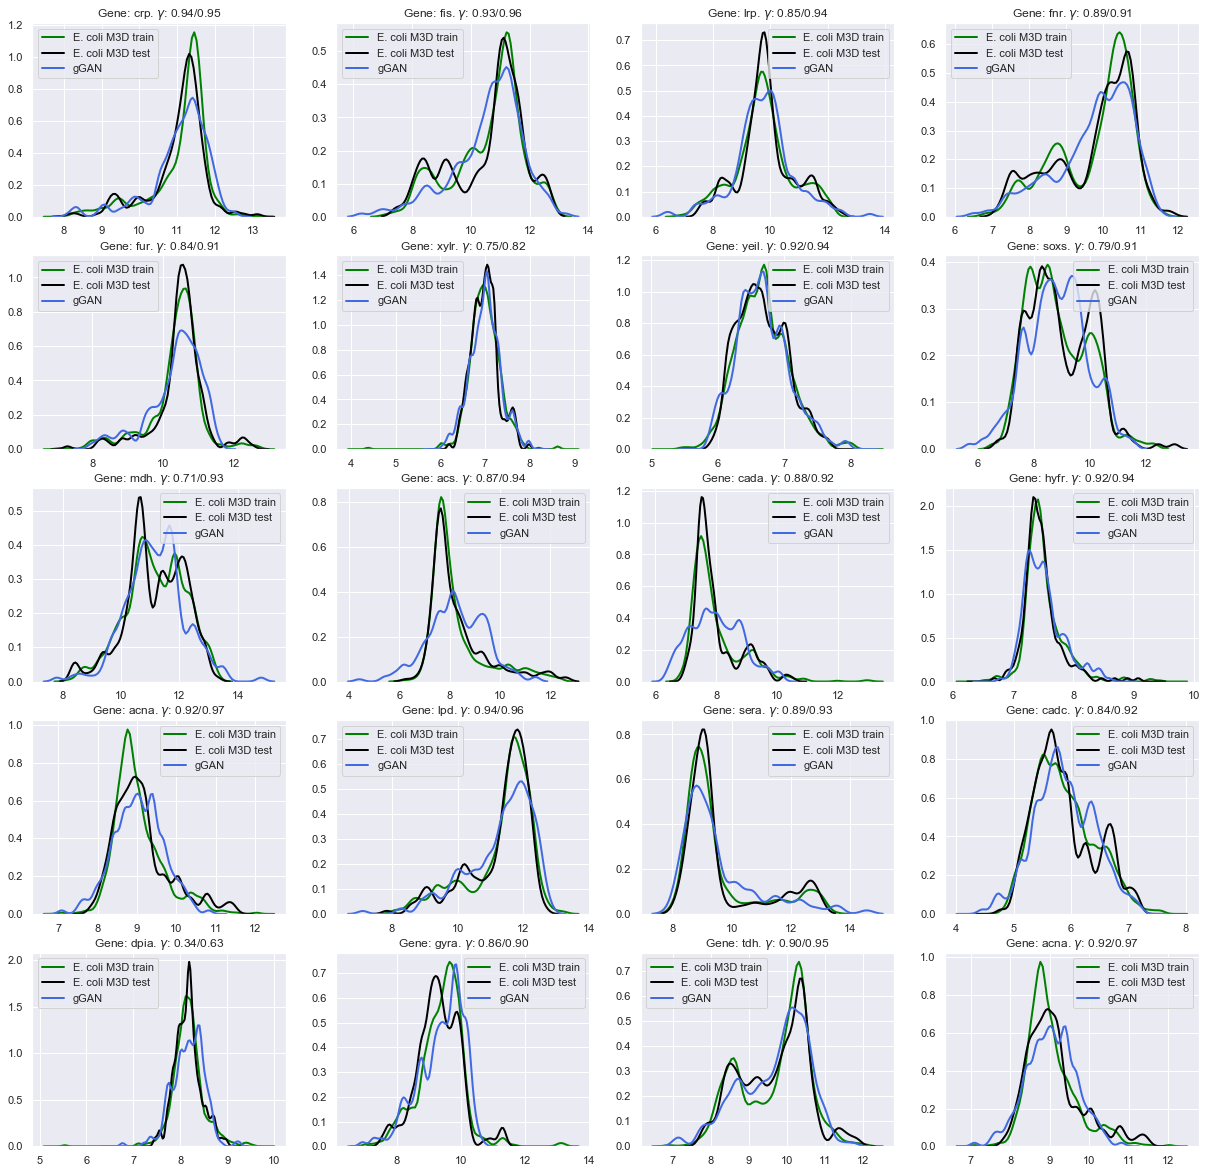

In [17]:
gene_list = ['crp', 'fis', 'lrp', 'fnr', # master regulators  'arca',
             'fur', 'xylr', 'yeil', 'soxs',
             'mdh', 'acs', 'cada', 'hyfr',
             'acna', 'lpd', 'sera', 'cadc',
             'dpia', 'gyra', 'tdh', 'acna']
nrows = 5
ncols = 4
assert nrows*ncols == len(gene_list)

dists_test = 1 - pearson_correlation(expr_test, expr_test)
dists_train = 1 - pearson_correlation(expr_train, expr_train)
dists_gan = 1 - pearson_correlation(gan_expr, gan_expr)

plt.figure(figsize=(18, 12))
plt.subplots_adjust(left=0, bottom=0, right=None, top=1.3, wspace=None, hspace=None)
for r in range(nrows):
    for c in range(ncols):
        idx = (nrows-1)*r + c
        plt.subplot(nrows, ncols, idx+1)
        idx = np.argwhere(np.array(gene_symbols) == gene_list[idx]).ravel()[0]
        
        gamma_dgan_dtest = pearson_correlation(dists_test[:, idx], dists_gan[:, idx])
        gamma_dtrain_dtest = pearson_correlation(dists_test[:, idx], dists_train[:, idx])
        plt.title('Gene: {}. $\gamma$: {:.2f}/{:.2f}'.format(gene_symbols[idx], gamma_dgan_dtest, gamma_dtrain_dtest))
        plot_distribution(expr_train[:, idx], xlabel='', ylabel='', label='E. coli M3D train', color='green');
        plot_distribution(expr_test[:, idx], xlabel='', ylabel='', label='E. coli M3D test', color='black');
        plot_distribution(gan_expr[:, idx], xlabel='', ylabel='', label='gGAN', color='royalblue');

# Compare sample background distribution

In [10]:
train_back_sample_corr = correlations_list(expr_train.T, expr_train.T)
r_back_sample_corr = correlations_list(expr_test.T, expr_test.T)
gan_back_sample_corr = correlations_list(gan_expr.T, gan_expr.T)

(-1, 1)

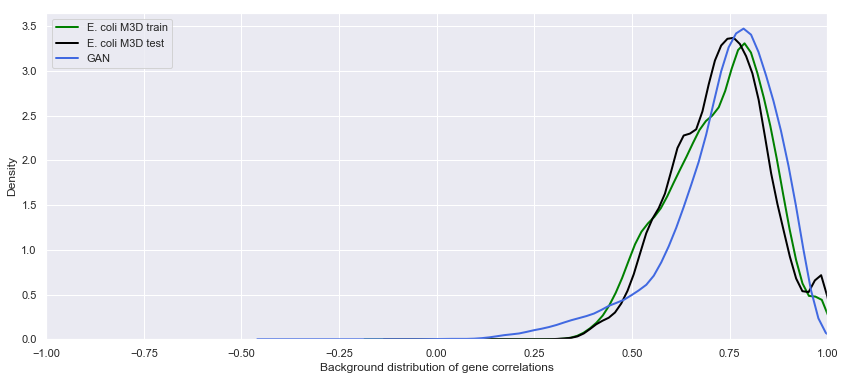

In [14]:
plt.figure(figsize=(14, 6))
ax = plot_distribution(train_back_sample_corr, label='E. coli M3D train', color='green')
ax = plot_distribution(r_back_sample_corr, label='E. coli M3D test', color='black')
ax = plot_distribution(gan_back_sample_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='GAN', color='royalblue')
ax.set_xlim((-1, 1))
# plt.tight_layout()
# plt.savefig('back_comp.pdf', bbox_inches = 'tight', pad_inches = 0);